<a href="https://colab.research.google.com/github/rajeshkpandey/AWESOME-FER/blob/master/Facial_recognition_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up


First, go to runtime->change runtime type -> and select GPU to improve the speed of training

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Mount google drive to enable file browsing. Else, the data saved in your files will be deleted when the runtime is over

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

# Process Data

Create directory for face images. Then, unzip the dataset from kaggle (or unzip my cleaned dataset) and move to directory

In [5]:
path = Path(base_dir+'faces')
path.mkdir(parents=True, exist_ok=True)

In [6]:
!unzip -o face-expression-recognition-dataset.zip 

unzip:  cannot find or open face-expression-recognition-dataset.zip, face-expression-recognition-dataset.zip.zip or face-expression-recognition-dataset.zip.ZIP.


In [7]:
#!mv images/ 'gdrive/My Drive/gaia/faces'

The np.random.seed(42) ensures that the random numbers are replicable. Using the fast.ai library, a image data bunch is created from the train and validation folders. </br>
All images are cropped to 244x244 since that is what the architecture resnet34 is trained on. The **transformations** adjust the photos by cropping, centering and zooming in the images. </br>
**Normalization** ensures that the three color channels (red green and blue) have pixel values that are normalized (mean of 0 and standard deviation of 1)

In [8]:
np.random.seed(42)
path_data = Path(base_dir+'faces/images/images')
data = ImageDataBunch.from_folder(path_data, train="train", valid="validation",
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.valid_ds

LabelList (7066 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sad,sad,sad,sad,sad
Path: /content/gdrive/My Drive/data/faces/images/images

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


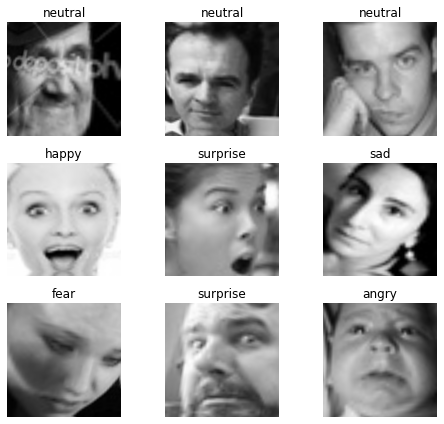

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


(7, 7)

# Training

We will use a learner to train the model. The learner takes in the image data bunch as well as the resnet34 architecture to train the model. The metrics will be used to print the error_rate when training

In [12]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Then we train the dataset. With learn.fit_one_cycle(4) we pass in the complete dataset four times. After 4 epochs, the error has been decreased to 29.8%

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.665292,1.424815,0.530569,1:11:32
1,1.301570,1.158041,0.451599,06:26
2,1.134489,1.060119,0.399236,06:25
3,1.068764,1.024343,0.387348,06:26


In [14]:
learn.save('stage-1')

In [15]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28830 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
surprise,surprise,surprise,surprise,surprise
Path: /content/gdrive/My Drive/data/faces/images/images;

Valid: LabelList (7066 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sad,sad,sad,sad,sad
Path: /content/gdrive/My Drive/data/faces/images/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

Before, we were only training the few extra layers of the model near the end. With **learn.unfreeze()** we are able to train the whole model. </br>
Then we find the learning rate, and the plot of loss over learning rate. From there, we find where the steepest downward slope of loss occurs (around 1e-4) and use it to fit 8 more epochs

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


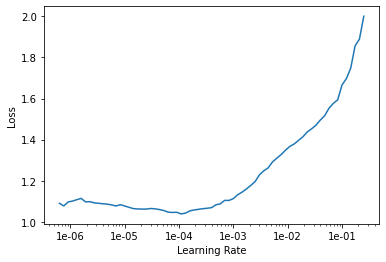

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.036934,1.012796,0.379847,08:35
1,1.012306,1.063304,0.394141,08:34
2,0.980640,0.935220,0.346023,08:33
3,0.904506,0.909926,0.337956,08:34
4,0.792285,0.848770,0.307812,08:33
5,0.699276,0.800693,0.286584,08:34
6,0.570656,0.784347,0.278658,08:33
7,0.523437,0.794062,0.274130,08:33


In [20]:
learn.save('stage-2')

In [21]:
learn.load('stage-2');

# Interpreting Results

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

For interpreting the results, it is clear from the confusion matrix that sad and neutral faces are often confused. This makes sense since many of the sad and neutral faces are similar and hard to distinguish

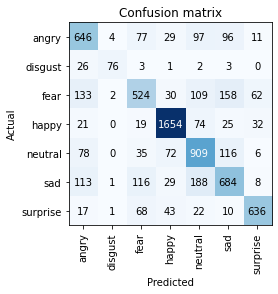

In [23]:
interp.plot_confusion_matrix()

Also, looking at the photos that caused the top losses, (difference between the predicted and the actual label) it is also clear that some data is still dirty and mislabelled, therefore there is still room for improvement

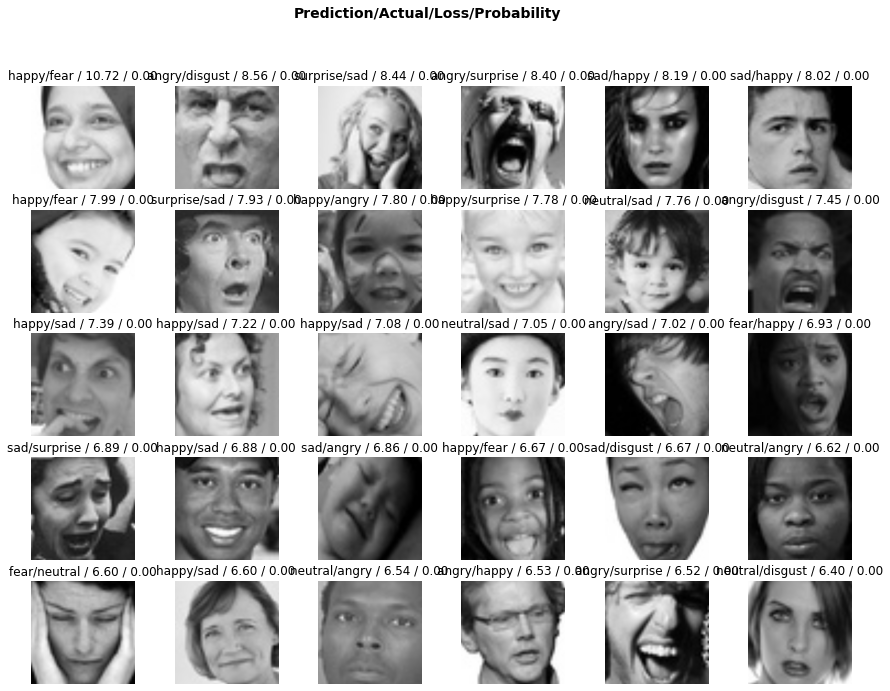

In [24]:
interp.plot_top_losses(30, figsize=(15,11))

Now export the model, and download it (export.pkl)

In [25]:
learn.export()